In [1]:
from math import exp
def future_discrete_value(x, r, n):
    return x*(1+r)**n

def today_discrete_value(x, r, n):
    return x*(1+r)**-n

def future_continous_value(x, r, n):
    return x*exp(r*n)

def today_continous_value(x, r, n):
    return x*exp(-r*n)
if __name__ == '__main__':
    x=100 #value of investemt
    r=0.05   #interest rate
    n=5      #duration(years)
    print("future x discrete value is:" , future_discrete_value(x, r, n))
    print("today x today value is:" , today_discrete_value(x, r, n))
    print("future x continous value is:", future_continous_value(x, r, n))
    print("today x continous value is:" , today_continous_value(x, r, n))

future x discrete value is: 127.62815625000003
today x today value is: 78.35261664684589
future x continous value is: 128.40254166877415
today x continous value is: 77.8800783071405


In [2]:
class ZeroCouponBonds():
    def __init__(self, principal, maturity, interest_rate): #sabitler
        self.principal=principal
        self.maturity=maturity
        self.interest_rate=interest_rate / 100
    
    def present_value(self, x, n):
        return x/(1 + self.interest_rate)**n
    
    def calculate_price(self):
        return self.present_value(self.principal, self.maturity)

if __name__ == '__main__':
    bond=ZeroCouponBonds(1000, 2, 4)
    print(bond.calculate_price())

924.5562130177514


In [3]:
class CouponBonds():
    def __init__(self, principal, rate, maturity, interest_rate): #sabitler
        self.principal=principal
        self.rate=rate / 100
        self.maturity=maturity
        self.interest_rate=interest_rate / 100
    
    def present_value(self, x, n):
        return x/(1 + self.interest_rate)**n
    
    def calculate_price(self):
        price=0
        #discount the coupon payment
        for t in range(1, self.maturity +1):
            price = price + self.present_value(self.principal * self.rate, t)
        #discout principal payment
        price = price + self.present_value(self.principal ,  self.maturity)
        return round(price, 2)

if __name__ == '__main__':
    bond=CouponBonds(1000, 10, 3, 4)
    print(bond.calculate_price())

1166.51


In [ ]:
##markowitz model implementation

In [15]:
import datetime
import urllib
import json
import numpy as np
import pandas as pd
import yfinance as y
import matplotlib.pyplot as plt
import scipy.optimize as optimization
from lxml import html
import requests
import re


def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

session1=requests.session()
kap_html=session1.get('https://www.kap.org.tr/tr/bist-sirketler').text
companies=[]
for row in kap_html.split('comp-row" >')[1:]:
	try:
		codes = re.findall('<div class="comp-cell _04 vtable">\s+<a[^<]+>([^<]*)</a>', row)[0].split(',')

		for code in codes:
			companies.append(code.strip())
	except:
	    pass

def stock_basket(names, periods=180):
    bitis=str(datetime.date.today()).replace("-","")
    baslangic = str(datetime.date.today() - datetime.timedelta(days=periods)).replace("-","")
    doviz=pd.DataFrame()
    for i in names:
        time_ = []
        close_ = []
        open_ = []
        high_ = []
        low_ = []
        volume_ = []
        temp_frame = pd.DataFrame(columns=['date','name','open','close','high','low','volume'])
        #print(i," collecting data...",end="")
    
        name = i
        temp_val = "https://web-paragaranti-pubsub.foreks.com/web-services/historical-data?userName=undefined&exchange=BIST&name="+name+"&market=E&group=E&last=500&period=1440&from="+baslangic+"000000&to="+bitis+"000000"
        with urllib.request.urlopen(temp_val) as url:
            data = json.loads(url.read().decode())
    
        data = data["dataSet"]
    
        for j in data:
            date_ = str(j["date"])[:10]
            time_.append(datetime.datetime.fromtimestamp(int(date_)).strftime('%Y-%m-%d'))
            close_.append(j["close"])
            open_.append(j["open"])
            high_.append(j["high"])
            low_.append(j["low"])
            volume_.append(j["volume"])
        
        
        temp_frame["date"] = time_
        temp_frame["name"] = name
        temp_frame["open"] = open_
        temp_frame["close"] = close_
        temp_frame["high"] = high_
        temp_frame["low"] = low_
        temp_frame["volume"] = volume_
        temp_frame["isCurrency"] = 0
        temp_frame['volume']= temp_frame['volume'].apply(value_to_float)
        doviz = doviz.append(temp_frame,ignore_index=True)
    return doviz

lis=stock_basket(companies, periods=10000)

In [ ]:
data=lis.pivot_table(index='date', columns='name', values='close').reset_index().rename_axis(None, axis=1).set_index('date')
data

In [ ]:
%matplotlib inline
def show_plot(data):
    data.plot(figsize=(12,8))
    plt.show()
show_plot(data)

In [ ]:
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

def calculate_return(data):
    log_return=np.log(data/data.shift(1))
    return log_return
    
def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()
    
def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)


def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()


def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])


# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


if __name__ == '__main__':
    show_data(data)
    log_daily_returns = calculate_return(data)
    show_statistics(log_daily_returns)

    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)



## capital asset pricing model  

In [ ]:
def return_index(data):
    
    

class CAMP():
    def __init__(self):
        self.data=None
        self.stocks=stocks
        self.start_date=start_date
        self.end_date=end_date
    def initialize(self):
        stock_data=data
        stock_data=stock_data.resample('M').last()


## Weiner process 

In [ ]:
import numpy as np
import pandas as pd

def weiner_process(dt=0.1, x0=0, n=1000):
    #initilliaze with 0
    W=np.zeros(n+1)
    # we craete timestamp
    t=np.linspace(x0, n, n+1)
    
    #we have to use cumulative sum: on every steps additional value is
    #drawn from a normal distribution with mean 0 and variance dt
    # by the way: N(0, dt) = sqrt(dt)*N(0,1) ususally this formula used
    
    W[1:n+1] = np.cumsum(np.random.normal(0, np.sqrt(dt), n))
    
    return t, W
def plot_the_process(t, W):
    plt.plot(t, W)
    plt.xlabel('Time(t)')
    plt.ylabel('Weiner-Process W(t)')
    plt.title('Weiner-Process')
    plt.show()
    
time, data =weiner_process(dt=0.1, x0=0, n=1000)

plot_the_process(time, data) 

In [ ]:
def simulate_geometric_brownian_motion(S0, T=2, N=1000, mu=0.05, sigma=0.005):
    
    dt=N/T
    t=np.linspace(0,T,N)
    W=np.random.standard_normal(size=N)
    
    W=np.cumsum(W) * np.sqrt(dt)
    
    X=(mu - 0.5 * sigma**2) * t * sigma * W
    
    S=S0 * np.exp(X)
    
    return t,S
    
t, W = simulate_geometric_brownian_motion(1,58589) 
plot_the_process(t, W)

## Black Scholes Model

In [10]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def call_option_price(S, E, T, rf, sigma):
    # calculate d1 and d2 
    d1=np.log(S/E) + (rf + (sigma*sigma/2)*T)/(sigma*np.sqrt(T))
    d2=d1-(sigma*np.sqrt(T))
    
    print(d1, d2)
    #standart normal dist to calculate price
    return S*stats.norm.cdf(d1) - E*np.exp(-rf*T)*stats.norm.cdf(d2)

def put_option_price(S, E, T, rf, sigma):
    # calculate d1 and d2 
    d1=np.log(S/E) + (rf + (sigma*sigma/2)*T)/(sigma*np.sqrt(T))
    d2=d1-(sigma*np.sqrt(T))
    
    print(d1, d2)
    #standart normal dist to calculate price
    return -S*stats.norm.cdf(-d1) + E*np.exp(-rf*T)*stats.norm.cdf(-d2)

S0=100    #stock price
E=100     #strike price
T=1       #expiry date 1 year
rf=0.05   # risk free rate
sigma=0.2 #volality of underlying stock

call_option_price(S0, E, T, rf, sigma) 

0.35000000000000003 0.15000000000000002


10.450583572185565

In [11]:
put_option_price(S0, E, T, rf, sigma)

0.35000000000000003 0.15000000000000002


5.573526022256971

## monte carlo simulations

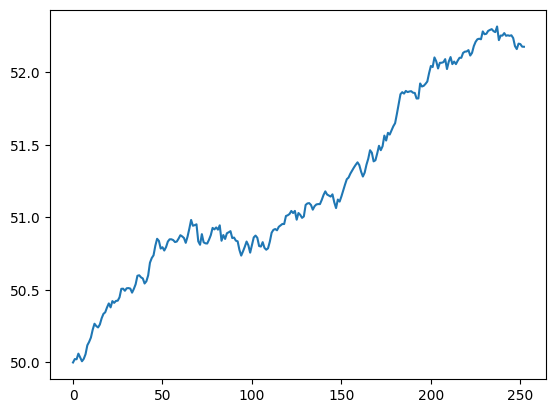

In [62]:
NUM_OF_SIMULATIONS=250

def stock_monte_carlo(S0, mu, sigma, N=1000):
    result=[]
    for _ in range(NUM_OF_SIMULATIONS):
        prices=[S0]
        for _ in range(N):
        #we simulate change day by day t=1
        
            stock_price=prices[-1] * np.exp((mu - 0.5*sigma**2) + sigma * np.random.normal())
            prices.append(stock_price)
        result.append(prices)
    sd=pd.DataFrame(result)
    sd=sd.T
    sd['mean']=sd.mean(axis=1)
    plt.plot(sd['mean'])
    plt.show()


stock_monte_carlo(50, 0.0002, 0.01, N=252)

## black scholes with monte carlo

In [14]:
class optionpricing():
    def __init__(self, S0, E, T, rf, sigma, iterations):
        self.S0=S0
        self.E=E
        self.T=T
        self.rf=rf
        self.sigma=sigma
        self.iterations=iterations
        
    def call_option(self):
        #we have 2 columns first with 0s second column will store payoffs
        option_data=np.zeros([self.iterations, 2])
        
        rand=np.random.normal(1,1, [1, self.iterations])
        
        #equation for stock price at T
        
        stock_price=self.S0 * np.exp(self.T * (self.rf - 0.5*sigma**2) + self.sigma * np.sqrt(self.T) * rand)
        
       # We need S E because we have to calculate the max(S-E, 0) 
        
        option_data[:,1] = stock_price - self.E
        #the average value
        average = np.sum(np.amax(option_data, axis=1)) / float(self.iterations)
        
        #we have to use discount opt exp(-rT)
        return np.exp(-1.0*self.rf * self.T) * average
    def put_option(self):
        #we have 2 columns first with 0s second column will store payoffs
        option_data=np.zeros([self.iterations, 2])
        
        rand=np.random.normal(1,1, [1, self.iterations])
        
        #equation for stock price at T
        
        stock_price=self.S0 * np.exp(self.T * (self.rf - 0.5*sigma**2) + self.sigma * np.sqrt(self.T) * rand)
        
       # We need S E because we have to calculate the max(S-E, 0) 
        
        option_data[:,1] = self.E - stock_price 
        #the average value
        average = np.sum(np.amax(option_data, axis=1)) / float(self.iterations)
        
        #we have to use discount opt exp(-rT)
        return np.exp(-1.0*self.rf * self.T) * average
        
opt=optionpricing(100,100,1,0.05, 0.2, 3000)
opt.put_option()

1.088397207426829

## variance at risk

In [26]:
data=lis.pivot_table(index='date', columns='name', values='close').reset_index().rename_axis(None, axis=1).set_index('date')
data.tail(2)

,ACSEL,ADEL,ADESE,AEFES,AFYON,AGESA,AGHOL,AGYO,AKBNK,AKCNS,...,YESIL,YGGYO,YGYO,YKBNK,YKSLN,YONGA,YUNSA,YYAPI,ZOREN,ZRGYO
date,,,,,,,,,,,,,,,,,,,,,
2022-04-28,46.98,24.48,0.78,29.62,3.76,20.40,39.4,2.62,8.97,21.42,...,1.55,22.34,0.83,4.91,8.61,21.72,22.50,1.03,2.03,2.85
2022-04-29,44.74,25.44,0.78,29.60,3.74,20.16,41.0,2.64,8.92,21.48,...,1.56,22.42,0.85,4.87,8.90,22.40,24.74,1.03,2.07,2.88


In [35]:
import datetime
from scipy.stats import norm
from dateutil.relativedelta import  *
from datetime import date, timedelta

In [38]:
def load_bitcoin(period=180):
    coindeskURL = 'https://api.coindesk.com/v1/bpi/historical/close.json?'
    end = date.today()
    start = end - timedelta(days=period)
    url = f'{coindeskURL}start={start:%Y-%m-%d}&end={end:%Y-%m-%d}'
    result = requests.get(url)
    data=json.loads(result.content)['bpi']
    df_bpi=pd.DataFrame(data, index=[0]).T
    df_bpi=df_bpi.reset_index()
    df_bpi.columns=['date', 'close']
    df_bpi.sort_values(by='date')
    return df_bpi
data_ex=load_bitcoin(period=2800)

In [60]:
data[['ACSEL']]

,ACSEL,ADEL,ADESE,AEFES,AFYON,AGESA,AGHOL,AGYO,AKBNK,AKCNS,...,YESIL,YGGYO,YGYO,YKBNK,YKSLN,YONGA,YUNSA,YYAPI,ZOREN,ZRGYO
date,,,,,,,,,,,,,,,,,,,,,
2014-06-11,1.9583,12.4806,2.7198,20.6595,0.7177,NaN,16.7246,0.7491,5.8776,7.9482,...,0.0395,2.5170,0.43,2.8344,NaN,NaN,4.1684,0.70,0.7628,NaN
2014-06-12,1.9954,12.5671,2.7340,21.1276,0.7209,NaN,16.7246,0.7491,5.9291,7.9174,...,0.0395,2.5077,0.43,2.8529,NaN,NaN,4.2363,0.70,0.7696,NaN
2014-06-13,2.0121,12.2712,2.7354,20.8151,0.7073,NaN,16.5378,0.7374,5.8490,7.7649,...,0.0390,2.5264,0.43,2.8228,NaN,NaN,4.2747,0.70,0.7561,NaN
2014-06-16,2.0159,12.1111,2.7657,20.7763,0.6972,NaN,15.8859,0.7315,5.6362,7.5216,...,0.0390,2.5077,0.42,2.7388,NaN,NaN,4.2520,0.70,0.7368,NaN
2014-06-17,2.0225,12.2220,2.7887,20.8151,0.7020,NaN,16.0253,0.7432,5.6590,7.5823,...,NaN,2.5170,0.42,2.7088,NaN,NaN,4.2826,0.70,0.7434,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,39.2000,25.1400,0.8000,29.6000,3.8900,21.36,40.0400,2.7600,9.3600,21.0000,...,1.5900,22.2800,0.89,5.1300,8.75,22.02,21.4600,1.06,2.0800,2.85
2022-04-26,43.1200,24.3000,0.7700,29.0400,3.7200,20.66,39.0200,2.6400,9.0300,21.2800,...,1.5600,22.2600,0.84,4.9400,8.55,22.06,21.3600,1.03,2.0000,2.83
2022-04-27,47.4200,24.4200,0.7600,28.9600,3.7300,20.18,39.3000,2.6200,9.1500,21.0800,...,1.5300,22.1600,0.84,4.9500,8.57,21.50,22.1200,1.02,2.0000,2.84


In [39]:
#for tommorow value at risk
def calculate_var(position, c, mu, sigma):
  
    var=position * (mu - sigma*norm.ppf(1-c))
    
    return var

#for any day in the future value at risk
def calculate_var_any(position, c, mu, sigma, n):
  
    var=position * (mu*n - sigma*np.sqrt(n)*norm.ppf(1-c))
    
    return var

data_ex['returns']=np.log(data_ex['close'] / data_ex['close'].shift(1))

In [44]:
S=200#1e6
c=0.99
mu=np.mean(data_ex['returns'])
sigma=np.std(data_ex['returns'])
calculate_var(S, c, mu, sigma)

18.52280273320541

In [45]:
calculate_var_any(S, c, mu, sigma, 2)

26.377625938733434

In [61]:
class value_at_risk_monte_carlo():
    def __init__(self, S, mu, sigma, c, n, iterations=100):
        self.S=S
        self.mu=mu
        self.sigma=sigma
        self.c=c
        self.n=n
        self.iterations=iterations
    def simulation(self):
        
        rand=np.random.normal(0, 1, [1, self.iterations])
        
        #random walk
        stock_price=self.S * np.exp(self.n * (self.mu - 0.5*sigma**2) + self.sigma * np.sqrt(self.n) * rand)
        stock_price=np.sort(stock_price)
        percentile = np.percentile(stock_price, (1-self.c)*100)
        return S - percentile
        


S=200
c=0.95
data_ex=data[['ACSEL']]
data_ex['returns']=data_ex['ACSEL'].pct_change()
mu=np.mean(data_ex['returns'])
sigma=np.std(data_ex['returns'])
n=1

model=value_at_risk_monte_carlo(S, c, mu, sigma, c, n)

model.simulation()

<ipython-input-61-8f1ad811fe52>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ex['returns']=data_ex['ACSEL'].pct_change()


-293.56823358695596

## The Ornstein-Uhlenbeck Process

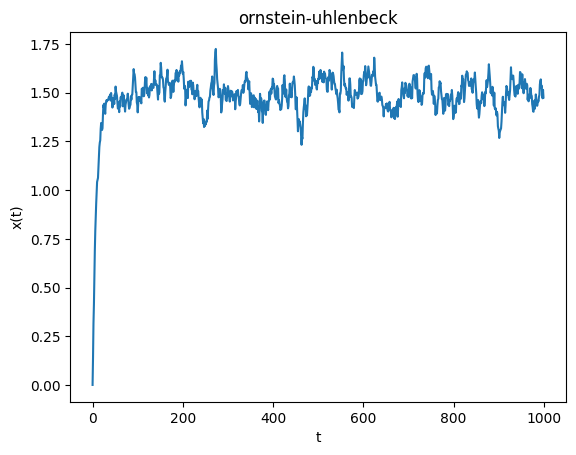

In [69]:
def generate_process(dt=0.1, theta=1.2, mu=1.5, sigma=0.1, n=1000):
    x=np.zeros(n)
    for t in range(1,n):
        x[t]=x[t-1] + theta*(mu - x[t-1])*dt + sigma*np.random.normal(0, np.sqrt(dt))
    return x
def plot_process(x):
    plt.plot(x)
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.title('ornstein-uhlenbeck')
    plt.show()
    
x=generate_process(dt=0.1, theta=1.2, mu=1.5, sigma=0.1, n=1000)
plot_process(x) 

## Vesicek Model

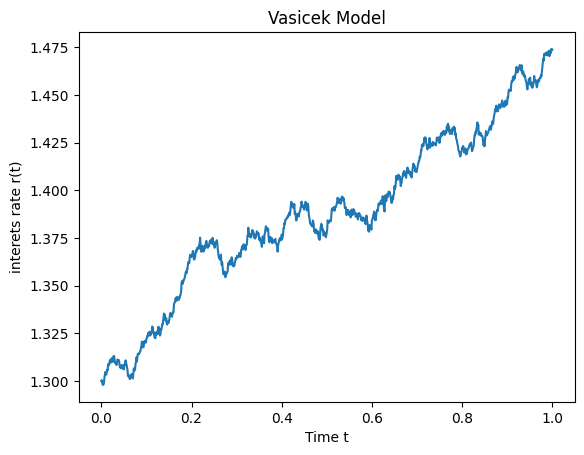

In [75]:
def generate_vesicek(r0, kappa, theta,  sigma, T=1, N=1000):
    dt=T/float(N)
    t=np.linspace(0, T, N+1)
    rates=[r0]
    
    for _ in range(N):
        dr=kappa*(theta - rates[-1])*dt + sigma*np.sqrt(dt)*np.random.normal()
        rates.append(rates[-1] + dr)
    return t, rates

def plot_vesicek(t, r):
    plt.plot(t, r)
    plt.xlabel('Time t')
    plt.ylabel('interets rate r(t)')
    plt.title('Vasicek Model')
    plt.show()

time, data=generate_vesicek(1.3, 0.9, 1.5, 0.05)
plot_vesicek(time, data)

In [83]:
#we will simulate 1000 r(t) interet rate process
NUM_OF_SIMULATIONS=1000

NUM_OF_POINTS=200

def monte_carlo_simulations_bond_prices(x, r0, kappa, theta, sigma, T=1):
    dt=T/float(NUM_OF_POINTS)
    results=[]
    
    for _ in range(NUM_OF_SIMULATIONS):
        rates=[r0]
        for _ in range (NUM_OF_POINTS):
            dr=kappa*(theta - rates[-1])*dt + sigma*np.sqrt(dt)*np.random.normal()
            rates.append(rates[-1] + dr)
        results.append(rates)
    simulation_data=pd.DataFrame(results).T
    
    integral_sum=simulation_data.sum()*dt
    
    present_integral_sum=np.exp(-integral_sum)
    
    bond_price= x * np.mean(present_integral_sum)
    
    print(bond_price) 


monte_carlo_simulations_bond_prices(1000, 0.1, 0.3, 0.3, 0.03) 

881.1772267566402


In [91]:
import requests
url = 'https://data.ibb.gov.tr/api/3/action/datastore_search?resource_id=1c043914-8a76-4793-bae9-c60a68c7d389'  
fileobj = requests.get(url).json()
df = pd.DataFrame(fileobj)

In [96]:
fileobj

{'help': 'https://data.ibb.gov.tr/api/3/action/help_show?name=datastore_search',
 'success': True,
 'result': {'include_total': True,
  'resource_id': '1c043914-8a76-4793-bae9-c60a68c7d389',
  'fields': [{'type': 'int', 'id': '_id'},
   {'info': {'notes': 'TR: Tarih, Saat, Dakika ve Saniye bilgisini içeren alandır. \n* Veri formati **YYYY-MM-DD HH24:MI:SS** formatındadır.\nEN: It is the field that contains date, hour, minute and second information. * Data format is in YYYY-MM-DD HH24: MI: SS format.',
     'type_override': 'TIMESTAMP',
     'label': 'Duyuru Başlangıç Tarihi'},
    'type': 'timestamp',
    'id': 'ANNOUNCEMENT_STARTING_DATETIME'},
   {'info': {'notes': 'TR: Tarih, Saat, Dakika ve Saniye bilgisini içeren alandır. \n* Veri formati **YYYY-MM-DD HH24:MI:SS** formatındadır.\nEN: It is the field that contains date, hour, minute and second information. * Data format is in YYYY-MM-DD HH24: MI: SS format.',
     'type_override': 'TIMESTAMP',
     'label': 'Duyuru Bitiş Tarihi'},
